# "Allcorrect Games"
> "We tackle an NLP multiclass classification challenge for a localization company"

- toc: true
- badges: true
- comments: true
- categories: [fastpages, jupyter]
- hide: false

# Problem Statement
- Allcorrect Games is looking to improve the speed at which they identify potential customers.
- The current bottleneck is manually labeling reviews into 4 categories
- We will attempt to resolve this using machine learning

## Data Description

- id - unique identifier
- mark - our RL, YL, L+, or L- label
    - RL – localization request;
    - L+ – good localization;
    - L- – bad localization;
    - YL – localization exists.
- review - The reviews to be classified

## Plan:
1. Examine the data for insights and errors
2. Clean up the reviews for processing and vectorization.
3. Examine class balance and test sampling methods.
4. Experiment with different vectorization methods and examine our results via Logistic Regression
5. Use a more advanced model and compare results

# Solution

## Import and examine the data

In [1]:
#collapse
import warnings
warnings.filterwarnings("ignore")

import math
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn')

from tqdm.auto import tqdm
tqdm.pandas()

import re

import spacy
import torch
import transformers

from sklearn.metrics import classification_report,accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from catboost import Pool, CatBoostClassifier

In [2]:
#hide
STATE = 12345
USE_GPU = True
SOURCE_FILE = 'C:/Users/The Ogre/datascience/allcorrectgames/reviews.xlsx'

In [3]:
#hide 
torch.cuda.is_available()

True

In [4]:
df_reviews = pd.read_excel(SOURCE_FILE, engine='openpyxl')

In [5]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51800 entries, 0 to 51799
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      51800 non-null  int64 
 1   mark    51800 non-null  object
 2   review  51800 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [6]:
df_reviews.head()

,id,mark,review
0,6720,RL,"It's not Turkish, it's a lie, but I recommend ..."
1,43313,RL,You don't have Korean
2,26549,RL,"Very nice, only if it were in Italian it would..."
3,42306,RL,The game is nice but when it comes to Turkish ...
4,32331,RL,"Amazing work, hope to achieve 100% Chinese tra..."


In [7]:
df_reviews['mark'].value_counts()

RL    42684
L-     5474
YL     2961
L+      666
Rl       10
l-        3
yl        1
Yl        1
Name: mark, dtype: int64

<AxesSubplot:>

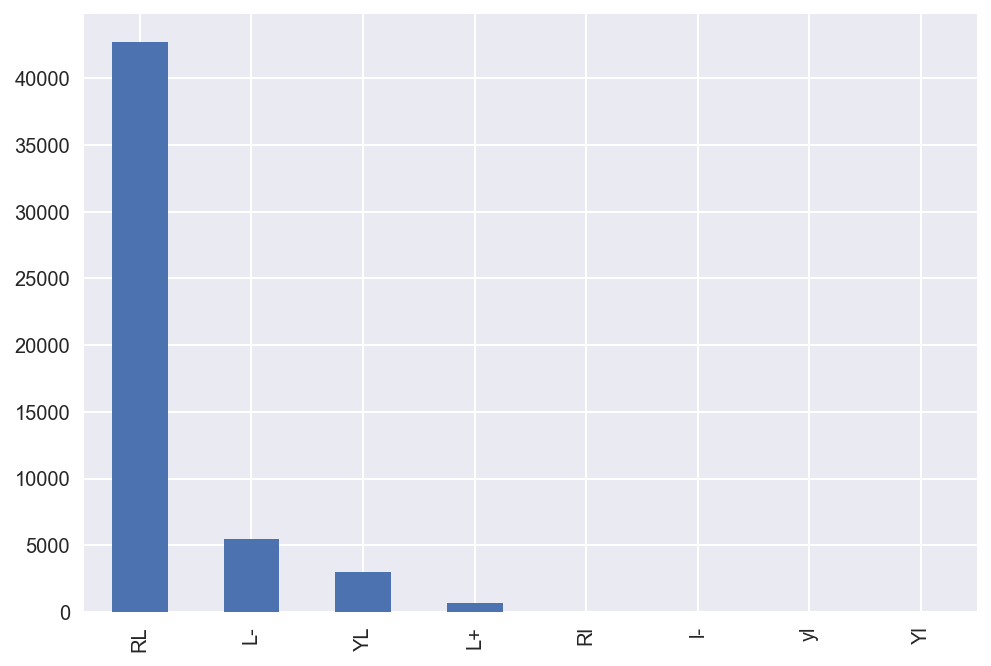

In [8]:
#collapse
df_reviews['mark'].value_counts().plot(kind='bar') 

- Categories need cleaning up, need to make them all Capital Letters

In [9]:
df_reviews['id'].duplicated().value_counts()

False    51800
Name: id, dtype: int64

In [10]:
df_reviews[df_reviews['review'].str.len() <= 5]['review'].value_counts()

👍        2
😕😕😕      1
??       1
.        1
Plz      1
When?    1
FROM     1
Pls      1
Good!    1
Great    1
👿        1
，        1
..       1
...      1
👍👍👍      1
Now      1
🇩🇰✌️     1
🙏🏽       1
Name: review, dtype: int64

- Removing these reviews. They are not long enough to have any value and appear to be errors in the initial algorithm gathering the reviews

In [11]:
df_reviews['review'].duplicated().value_counts()

False    48515
True      3285
Name: review, dtype: int64

In [12]:
df_reviews[df_reviews['review'].duplicated()]['review'].value_counts().head()

Would like to have Thai language    181
No Russian language                  85
Turkish language please              62
Add Russian                          60
Please add the Arabic language       54
Name: review, dtype: int64

- Duplicates area a natural occurence in the data set, so we are going to leave them

## Clean the Data

In [13]:
df_reviews = df_reviews[df_reviews['review'].str.len() > 5]
df_reviews.reset_index(drop=True, inplace=True)

In [14]:
df_reviews['mark'] = df_reviews['mark'].str.upper()

RL    42676
L-     5477
YL     2962
L+      666
Name: mark, dtype: int64

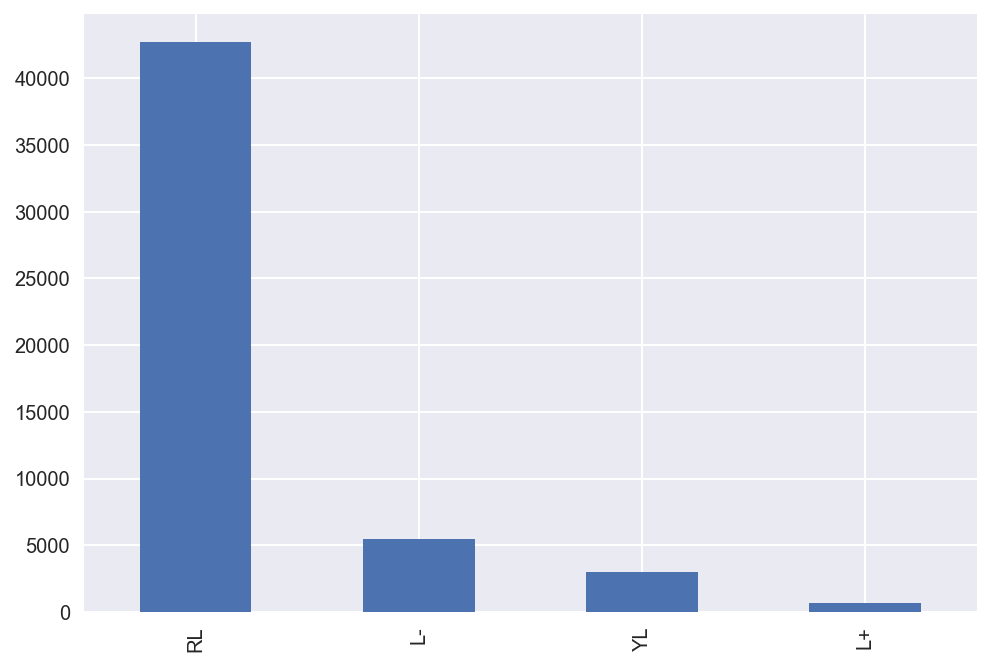

In [15]:
#collapse
df_reviews['mark'].value_counts().plot(kind='bar') 
df_reviews['mark'].value_counts()

- All labels have been properly corrected

In [16]:
#collapse
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how does",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
" u ": " you ",
" ur ": " your ",
" n ": " and ",
"won't": "would not",
'dis ': 'this ',
'bak ': 'back ',
'brng': 'bring'}

In [17]:
def cont_to_exp(x):
    if type(x) is str:
        for key in contractions:
            value = contractions[key]
            x = x.replace(key, value)
        return x
    else:
        return x

In [18]:
def clear_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z']+", " ", text) 
    return " ".join(text.split())

In [19]:
df_reviews['review_norm'] = df_reviews['review'].progress_apply(clear_text)

In [20]:
df_reviews['review_norm'] = df_reviews['review_norm'].progress_apply(cont_to_exp)

In [21]:
df_reviews['review_norm'].head()

0    it is not turkish it is a lie but i recommend ...
1                               you do not have korean
2    very nice only if it were in italian it would ...
3    the game is nice but when it comes to turkish ...
4     amazing work hope to achieve chinese translation
Name: review_norm, dtype: object

- Reviews are now all lower case and contractions have been removed to simplify vectorization

## Sampling

- Both upsampling and downsampling were attempted on this dataset
- No improvement to results were achieved so the code was removed to declutter 

## Split the Data

In [22]:
train, test = train_test_split(df_reviews, 
                               test_size=0.25, 
                               stratify = df_reviews['mark'], 
                               random_state=STATE)

In [23]:
X_train = train.drop(['id', 'review', 'mark'], axis=1)
y_train = train['mark']

X_test = test.drop(['id', 'review', 'mark'], axis=1)
y_test = test['mark']

In [24]:
display(X_train.shape[0])
X_test.shape[0]

38835

12946

In [25]:
y_train.value_counts()

RL    32006
L-     4108
YL     2221
L+      500
Name: mark, dtype: int64

In [26]:
y_test.value_counts()

RL    10670
L-     1369
YL      741
L+      166
Name: mark, dtype: int64

## Logistic Regression Model

### Count Vectorizer

In [27]:
corpus = X_train['review_norm']
count_vect = CountVectorizer(stop_words='english', ngram_range=(2,3), max_features=30000)
X_train_1 = count_vect.fit_transform(corpus)

In [28]:
corpus = X_test['review_norm']
X_test_1 = count_vect.transform(corpus)

In [29]:
grid={
    "penalty":["l2"],
    "fit_intercept": [True, False],
    "random_state": [STATE],
    "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
    "max_iter": [1000],
    "multi_class": ["ovr", "multinomial"],
    "n_jobs": [-1],
}

In [30]:
model_lr = LogisticRegression()

lr_cv=GridSearchCV(model_lr,grid,cv=5)
lr_cv.fit(X_train_1 ,y_train)

print("Tuned Hyperparameters:", lr_cv.best_params_)
print("Accuracy:", lr_cv.best_score_)

Tuned Hyperparameters: {'fit_intercept': True, 'max_iter': 1000, 'multi_class': 'multinomial', 'n_jobs': -1, 'penalty': 'l2', 'random_state': 12345, 'solver': 'saga'}
Accuracy: 0.8754731556585554


- This cell can take hours to run
- If significant changes to preprocessing or data, please run again

In [31]:
model_lr = LogisticRegression(**lr_cv.best_params_)

model_lr.fit(X_train_1, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial', n_jobs=-1,
                   random_state=12345, solver='saga')

In [32]:
pred = model_lr.predict(X_test_1)
print(classification_report(y_test,pred))
print(accuracy_score(y_test,pred))

              precision    recall  f1-score   support

          L+       0.65      0.19      0.30       166
          L-       0.80      0.52      0.63      1369
          RL       0.89      0.98      0.94     10670
          YL       0.58      0.17      0.27       741

    accuracy                           0.88     12946
   macro avg       0.73      0.47      0.53     12946
weighted avg       0.86      0.88      0.86     12946

0.8791132396106905


- These are strong results for Logistic Regression
- Not enough unique data for the smaller categories it seems

### Tfidf Vectorizer

In [33]:
corpus = X_train['review_norm']
tfidf_vect= TfidfVectorizer(stop_words='english', ngram_range=(2,3), max_features=30000)
X_train_2 = tfidf_vect.fit_transform(corpus)

In [34]:
corpus = X_test['review_norm']
X_test_2 = tfidf_vect.transform(corpus)

In [35]:
model_lr_2 = LogisticRegression()

lr_cv=GridSearchCV(model_lr_2,grid,cv=5)
lr_cv.fit(X_train_2 ,y_train)

print("Tuned Hyperparameters:", lr_cv.best_params_)
print("Accuracy:", lr_cv.best_score_)

Tuned Hyperparameters: {'fit_intercept': True, 'max_iter': 1000, 'multi_class': 'multinomial', 'n_jobs': -1, 'penalty': 'l2', 'random_state': 12345, 'solver': 'saga'}
Accuracy: 0.8592764259044676


- This cell can take hours to run
- Results are hardcoded to avoid rerunning hours of calculations
- If significant changes to preprocessing or data, please run again

In [36]:
model_lr_2 = LogisticRegression(**lr_cv.best_params_)
                                
model_lr_2.fit(X_train_2, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial', n_jobs=-1,
                   random_state=12345, solver='saga')

In [37]:
pred = model_lr_2.predict(X_test_2)
print(classification_report(y_test,pred))
print(accuracy_score(y_test,pred))

              precision    recall  f1-score   support

          L+       0.60      0.05      0.10       166
          L-       0.84      0.44      0.58      1369
          RL       0.87      0.99      0.93     10670
          YL       0.84      0.05      0.09       741

    accuracy                           0.87     12946
   macro avg       0.79      0.38      0.42     12946
weighted avg       0.86      0.87      0.83     12946

0.869457747566816


- Significantly worse results on the smaller categories
- Count Vectorizer is the clear winner here

## Catboost Model

In [38]:
text_features = ['review_norm']

In [60]:
train_pool = Pool(
    X_train, 
    y_train,  
    text_features=text_features, 
    feature_names=list(X_train)
)
valid_pool = Pool(
    X_test, 
    y_test,
    text_features=text_features, 
    feature_names=list(X_train)
)

catboost_params = {
    'iterations': 5000,
    'learning_rate': 0.03,
    'eval_metric': 'TotalF1',
    'task_type': 'GPU' if USE_GPU else 'CPU',
    'early_stopping_rounds': 2000,
    'use_best_model': True,
    'verbose': 500,
    'random_state': STATE
}

In [40]:
model_cb = CatBoostClassifier(**catboost_params)
model_cb.fit(train_pool, eval_set=valid_pool)

0:	learn: 0.8517705	test: 0.8532483	best: 0.8532483 (0)	total: 28.7ms	remaining: 2m 23s
500:	learn: 0.8950334	test: 0.8904317	best: 0.8904748 (499)	total: 10.8s	remaining: 1m 37s
1000:	learn: 0.9092785	test: 0.8978792	best: 0.8983240 (947)	total: 21.7s	remaining: 1m 26s
1500:	learn: 0.9170555	test: 0.9014397	best: 0.9017088 (1487)	total: 32.6s	remaining: 1m 15s
2000:	learn: 0.9232431	test: 0.9042233	best: 0.9043929 (1986)	total: 43.5s	remaining: 1m 5s
2500:	learn: 0.9278779	test: 0.9054554	best: 0.9057675 (2439)	total: 54.4s	remaining: 54.4s
3000:	learn: 0.9318730	test: 0.9062368	best: 0.9065412 (2887)	total: 1m 5s	remaining: 43.6s
3500:	learn: 0.9347331	test: 0.9078687	best: 0.9079615 (3480)	total: 1m 16s	remaining: 32.7s
4000:	learn: 0.9373805	test: 0.9088320	best: 0.9088320 (4000)	total: 1m 27s	remaining: 21.8s
4500:	learn: 0.9400044	test: 0.9094047	best: 0.9098289 (4252)	total: 1m 37s	remaining: 10.9s
4999:	learn: 0.9423276	test: 0.9102575	best: 0.9104906 (4982)	total: 1m 48s	remai

In [41]:
pred = model_cb.predict(X_test)
print(classification_report(y_test,pred))
print(accuracy_score(y_test,pred))

              precision    recall  f1-score   support

          L+       0.65      0.23      0.35       166
          L-       0.80      0.79      0.79      1369
          RL       0.94      0.98      0.96     10670
          YL       0.77      0.43      0.55       741

    accuracy                           0.92     12946
   macro avg       0.79      0.61      0.66     12946
weighted avg       0.91      0.92      0.91     12946

0.9181986714042948


- Very strong results for RL category
- The trend appears to be that with more data points the models accuracy increases in a category

## Experiment on Multiple Model Usage

### Phase 1 - Localization Requests

In [42]:
reviews_set_1 = df_reviews.copy()

In [43]:
for i in range(len(reviews_set_1)):
     if reviews_set_1['mark'][i] != 'RL':
            reviews_set_1['mark'][i] = 'YL'

In [44]:
reviews_set_1['mark'].value_counts()               

RL    42676
YL     9105
Name: mark, dtype: int64

In [45]:
X1 = reviews_set_1.drop(['id', 'review', 'mark'], axis=1)
y1 = reviews_set_1['mark']

In [46]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1,y1, test_size=0.25, stratify = y1)

In [61]:
train_pool_2 = Pool(
    X1_train, 
    y1_train,  
    text_features=text_features, 
    feature_names=list(X1_train)
)
valid_pool_2 = Pool(
    X1_test, 
    y1_test,
    text_features=text_features, 
    feature_names=list(X1_train)
)

In [48]:
model1 = CatBoostClassifier(**catboost_params)
model1.fit(train_pool_2, eval_set=valid_pool_2)

0:	learn: 0.8866448	test: 0.8891357	best: 0.8891357 (0)	total: 60.6ms	remaining: 5m 2s
500:	learn: 0.9226201	test: 0.9155004	best: 0.9156253 (494)	total: 28.6s	remaining: 4m 16s
1000:	learn: 0.9332266	test: 0.9222860	best: 0.9222860 (1000)	total: 56.7s	remaining: 3m 46s
1500:	learn: 0.9405186	test: 0.9246324	best: 0.9248068 (1487)	total: 1m 24s	remaining: 3m 17s
2000:	learn: 0.9457609	test: 0.9258364	best: 0.9260103 (1830)	total: 1m 52s	remaining: 2m 48s
2500:	learn: 0.9501938	test: 0.9264900	best: 0.9266340 (2435)	total: 2m 20s	remaining: 2m 19s
3000:	learn: 0.9533795	test: 0.9268223	best: 0.9275135 (2844)	total: 2m 47s	remaining: 1m 51s
3500:	learn: 0.9567446	test: 0.9272541	best: 0.9275135 (2844)	total: 3m 15s	remaining: 1m 23s
4000:	learn: 0.9593883	test: 0.9279158	best: 0.9281178 (3914)	total: 3m 43s	remaining: 55.8s
4500:	learn: 0.9618747	test: 0.9285048	best: 0.9285048 (4491)	total: 4m 11s	remaining: 27.9s
4999:	learn: 0.9639499	test: 0.9284468	best: 0.9287630 (4944)	total: 4m 3

In [49]:
pred1 = model1.predict(X1_test)
print(classification_report(y1_test,pred1))
print(accuracy_score(y1_test,pred1))

              precision    recall  f1-score   support

          RL       0.95      0.97      0.96     10670
          YL       0.84      0.75      0.79      2276

    accuracy                           0.93     12946
   macro avg       0.89      0.86      0.87     12946
weighted avg       0.93      0.93      0.93     12946

0.9304032133477522


### Phase 2 - Localization Reviews

In [50]:
reviews_set_2 = df_reviews.copy()

In [51]:
reviews_set_2 = reviews_set_2[reviews_set_2['mark'] != 'RL']

In [52]:
reviews_set_2['mark'].value_counts()  

L-    5477
YL    2962
L+     666
Name: mark, dtype: int64

In [53]:
X2 = reviews_set_2.drop(['id', 'review', 'mark'], axis=1)
y2 = reviews_set_2['mark']

In [54]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y2, test_size=0.25, stratify = y2)

In [62]:
train_pool_3 = Pool(
    X2_train, 
    y2_train,  
    text_features=text_features, 
    feature_names=list(X2_train)
)
valid_pool_3 = Pool(
    X2_test, 
    y2_test,
    text_features=text_features, 
    feature_names=list(X2_train)
)

In [56]:
model2 = CatBoostClassifier(**catboost_params)
model2.fit(train_pool_3, eval_set=valid_pool_3)

0:	learn: 0.7968397	test: 0.8152103	best: 0.8152103 (0)	total: 25.9ms	remaining: 2m 9s
500:	learn: 0.8476542	test: 0.8385124	best: 0.8385909 (493)	total: 10s	remaining: 1m 29s
1000:	learn: 0.8767694	test: 0.8500063	best: 0.8500063 (995)	total: 20.1s	remaining: 1m 20s
1500:	learn: 0.8962401	test: 0.8518733	best: 0.8529896 (1485)	total: 30.3s	remaining: 1m 10s
2000:	learn: 0.9091538	test: 0.8553469	best: 0.8558676 (1950)	total: 40.1s	remaining: 1m
2500:	learn: 0.9181506	test: 0.8573688	best: 0.8573688 (2474)	total: 49.8s	remaining: 49.7s
3000:	learn: 0.9274049	test: 0.8598072	best: 0.8598072 (2976)	total: 59.6s	remaining: 39.7s
3500:	learn: 0.9361894	test: 0.8619213	best: 0.8622723 (3151)	total: 1m 9s	remaining: 29.7s
4000:	learn: 0.9431237	test: 0.8620891	best: 0.8634842 (3565)	total: 1m 19s	remaining: 19.9s
4500:	learn: 0.9481487	test: 0.8619907	best: 0.8634842 (3565)	total: 1m 29s	remaining: 9.97s
4999:	learn: 0.9529232	test: 0.8618240	best: 0.8634842 (3565)	total: 1m 39s	remaining: 0

In [57]:
pred2 = model2.predict(X2_test)
print(classification_report(y2_test,pred2))
print(accuracy_score(y2_test,pred2))

              precision    recall  f1-score   support

          L+       0.69      0.31      0.43       166
          L-       0.89      0.95      0.92      1370
          YL       0.85      0.86      0.86       741

    accuracy                           0.87      2277
   macro avg       0.81      0.71      0.74      2277
weighted avg       0.87      0.87      0.86      2277

0.873078612209047


- Strong results so far, significantly better than a single Logistic Regression model
- It appears, as mentioned before, more data points are needed to improve
- Errors in the first model will compound into the second model under this approach

# Final Conclusion
 

- Catboost was our strongest performing model with a 96% accuracy for RL (Localization Requests)
- No model performed well at predicting the minority targets of YL, L+, and L-.
- We need more data! The dataset is heavily imbalanced at this time.
- We can potentially negate 80% of the manual labeling work by relying on the single Catboost model
- If the minority categories are more important, the 2 model approach yielded better results on this front.
- Without more data our next steps for seeking improvement are creating a Deep Learning/Neural Network

## Implementation

- A python file has been provided to Allcorrect Games, once run they can call label_catboost_excel(File_Path, Model_Path) in the terminal.  
- The script will add a predictions column to the dataset using the catboost model from our single model approach